## Example 27 - Anisotropic System
The rotor system shown in Figure 6.18 consists of a shaft 1.5 m long with a 50 mm diameter supported by bearings at each end. Disks are mounted on the shaft at one-third and two-third spans. Each disk is 70 mm thick and the left and right disks are 280 and 350 mm in diameter, respectively. The shaft and disks have material properties E — 211 GPa, G = 81.1 GPa, and p — 7,810 kg/m3. Determine the response of the system at the disks due to an out-of-balance on the left disk of 0.001 kgm, if each bearing has a stiffness of 1 MN/m in the x direction and 0.8 MN/m in the y direction and a damping of 100 Ns/m in both directions. The natural frequencies and mode shapes for these rotor systems are calculated in Examples 5.9.1 and 5.9.2.

This example is based on Example 6.3.1.b page 253 from [Friswell, 2010].

In [1]:
import ross as rs
import plotly.graph_objects as go
import plotly.io as pio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# uncomment the lines below if you are having problems with plots not showing
# import plotly.io as pio
# pio.renderers.default = "notebook"

Q_ = rs.Q_

In [2]:
steel = rs.Material("steel", E=211e9, G_s=81.1e9, rho=7810)

### Defining bearings, shaft and disk elements and Creating Anisotropic Rotor

In [3]:
N = 6
L = 1.5/N
idl = 0
odl = 0.050   # shaft diameter

shaft = [rs.ShaftElement(L=L, idl=idl, odl=odl, material=steel) for i in range(N)]
bearings = [
    rs.BearingElement(n=0, kxx=1e6, kyy=0.8e6, cxx=100, cyy=100),
    rs.BearingElement(n=6, kxx=1e6, kyy=0.8e6, cxx=100, cyy=100),
]
disks = [
    rs.DiskElement.from_geometry(
        n=N/3, material=steel, width=0.070, i_d=odl, o_d=0.280, scale_factor="mass"
    ),
    rs.DiskElement.from_geometry(
        n=2*N/3, material=steel, width=0.070, i_d=odl, o_d=0.350, scale_factor="mass"
    )
]

rotor = rs.Rotor(shaft_elements=shaft, disk_elements=disks, bearing_elements=bearings)
rotor.plot_rotor(width=750, height=500)

## Plotting the Campbell Diagram

In [4]:
campbell = rotor.run_campbell(speed_range=Q_(np.linspace(0, 6500, 65), "RPM"))

In [5]:
fig = campbell.plot(frequency_units="RPM", width=600, height=600)
for i in fig.data:
    try:
        i['y'] = i['y'] / 60
    except:
        pass
fig.update_yaxes(title='Natural Frequencies (Hz)', range=[0, 150])
fig.update_xaxes(title='Rotor Spin Speed (rpm)', range=[0, 6500])

## Plotting the Mode Shapes and Damped Natural Frequencies

In [6]:
speed =  Q_(3000, "RPM")
modal = rotor.run_modal(speed)

for i in np.arange(0, 6, 1):
    modal.plot_mode_3d(mode=i, frequency_units="Hz", damping_parameter="damping_ratio").show()

## Creating the out-of-balancing

In [7]:
n1 = 2    # out-of-balancing is positioned at the left disk
m1 = 0.001  # amount of out-of-balancing expressed in kg*m
p1 = 0      # ou-of-balancing mass phase position
speed = Q_(np.linspace(10, 4500, 1950),"RPM")
results_case1 = rotor.run_unbalance_response([n1], [m1], [p1], speed)

In [8]:
probe1 = (2, 0)                  # response in x axis (0 degrees) at the left disk of rotor (node = 2)
probe2 = (2, Q_(90, "deg"))      # response in y axis (90 degrees) at the left disk of rotor (node = 2)
fig = results_case1.plot_magnitude(probe=[probe1,probe2], probe_units="degrees",frequency_units="RPM", amplitude_units="µm pkpk")

# changing to log scale 
fig.update_layout(
        yaxis=dict(
            type='log',
        )
    )

In [9]:
probe1 = (4, 0)                  # response in x axis (0 degrees) at the right disk of rotor (node = 4)
probe2 = (4, Q_(90, "deg"))      # response in y axis (90 degrees) at the right disk of rotor (node = 4)
fig = results_case1.plot_magnitude(probe=[probe1,probe2], probe_units="degrees",frequency_units="RPM", amplitude_units="µm pkpk")

In [10]:
# changing to log scale 
fig.update_layout(
        yaxis=dict(
           type='log'
        )
    )

## Plotting the Orbit using the Plotly library

In [11]:
#### Building the orbit at 751 RPM, 800 RPM and 2320 RPM for nodes located at 
#### the right and left disks (node=2 and node=4)

#### At 751 RPM

In [12]:
speed =  751*(2*np.pi/60)  #Q_(496, "RPM")
time_samples = 1000001
node = 2   # out-of-balancing position
t = np.linspace(0, 43, time_samples)

# Creating the out-of-balancing force input matrix
F = np.zeros((time_samples, rotor.ndof))

# harmonic force component on x axis
F[:, 4 * node + 0] = m1*speed**2 * np.cos(speed * t)  # as out-of-balancing is a harmonic force

# harmonic force component on y axis
F[:, 4 * node + 1] = m1*speed**2 * np.sin(speed * t)   # as out-of-balancing is a harmonic force

# Using the ROSS’ method to calculate displacements due a force in time domain: run_time_response().

response3 = rotor.run_time_response(speed, F, t)

In [13]:
# Editing the ross plots in order to explicit the orbit whirl in node 2 

orb2 = response3.plot_2d(node=2, width = 500, height = 500)
cutoff = int(1000*1.8)
x_new2 = orb2.data[0].x[-cutoff:]
y_new2 = orb2.data[0].y[-cutoff:]

# Inserting the orbit starting point
starting_point2= go.Scatter(
    x=[x_new2[0]],
    y=[y_new2[0]],
    marker={'size': 10, 'color': 'orange'},
    showlegend=False,
    name='Starting Point2'
)

# Inserting the orbit of node 2
orb2_curve= go.Scatter(
    x=x_new2,
    y=y_new2,
    mode='lines',
    name='orb2',
    showlegend=False,
    line=dict(color='orange')
)

# Editing the ross plots in order to explicit the orbit whirl in node 4 

orb4 = response3.plot_2d(node=4, width = 500, height = 500)

x_new4 = orb4.data[0].x[-cutoff:]
y_new4 = orb4.data[0].y[-cutoff:]

# Inserting the orbit starting point
starting_point4= go.Scatter(
    x=[x_new4[0]],
    y=[y_new4[0]],
    marker={'size': 10, 'color': '#636EFA'},
    showlegend=False,
    name='Starting Point4'
)

# Proper scaling x and y axis
max_amp = max(np.max(x_new2), np.max(y_new2), np.max(x_new4), np.max(y_new4))

# Merging orbit at node 2 and node 4 
orb4.update_xaxes(range = [-1.2 * max_amp, 1.2 * max_amp])
orb4.update_yaxes(range = [-1.2 * max_amp, 1.2 * max_amp])
orb4.update_traces(x = x_new4 , y = y_new4, name = 'orb4')
orb4.update_layout(title = 'Response at node 2 and 4 at 751 RPM')
orb4.add_trace(starting_point4)
orb4.add_trace(starting_point2)
orb4.add_trace(orb2_curve)
orb4

#### At 800 RPM

In [14]:
speed =  800*(2*np.pi/60)  #Q_(496, "RPM")
time_samples = 1000001
node = 2   # out-of-balancing position
t = np.linspace(0, 43, time_samples)

# Creating the out-of-balancing force input matrix
F = np.zeros((time_samples, rotor.ndof))

# harmonic force component on x axis
F[:, 4 * node + 0] = m1*speed**2 * np.cos(speed * t)  # as out-of-balancing is a harmonic force

# harmonic force component on y axis
F[:, 4 * node + 1] = m1*speed**2 * np.sin(speed * t)   # as out-of-balancing is a harmonic force

# Using the ROSS’ method to calculate displacements due a force in time domain: run_time_response().

response3 = rotor.run_time_response(speed, F, t)

In [15]:
# Editing the ross plots in order to explicit the orbit whirl in node 2 

orb2 = response3.plot_2d(node=2, width = 500, height = 500)
cutoff = int(1000*1.7)
x_new2 = orb2.data[0].x[-cutoff:]
y_new2 = orb2.data[0].y[-cutoff:]

# Inserting the orbit starting point
starting_point2= go.Scatter(
    x=[x_new2[0]],
    y=[y_new2[0]],
    marker={'size': 10, 'color': 'orange'},
    showlegend=False,
    name='Starting Point2'
)

# Inserting the orbit of node 2
orb2_curve= go.Scatter(
    x=x_new2,
    y=y_new2,
    mode='lines',
    name='orb2',
    showlegend=False,
    line=dict(color='orange')
)

# Editing the ross plots in order to explicit the orbit whirl in node 4 

orb4 = response3.plot_2d(node=4, width = 500, height = 500)

x_new4 = orb4.data[0].x[-cutoff:]
y_new4 = orb4.data[0].y[-cutoff:]

# Inserting the orbit starting point
starting_point4= go.Scatter(
    x=[x_new4[0]],
    y=[y_new4[0]],
    marker={'size': 10, 'color': '#636EFA'},
    showlegend=False,
    name='Starting Point4'
)

# Proper scaling x and y axis
max_amp = max(np.max(x_new2), np.max(y_new2), np.max(x_new4), np.max(y_new4))

# Merging orbit at node 2 and node 4 
orb4.update_xaxes(range = [-1.2 * max_amp, 1.2 * max_amp])
orb4.update_yaxes(range = [-1.2 * max_amp, 1.2 * max_amp])
orb4.update_traces(x = x_new4 , y = y_new4, name = 'orb4')
orb4.update_layout(title = 'Response at node 2 and 4 at 800 RPM')
orb4.add_trace(starting_point4)
orb4.add_trace(starting_point2)
orb4.add_trace(orb2_curve)
orb4

#### At 2320 RPM

In [16]:
speed =  2320*(2*np.pi/60)  #Q_(496, "RPM")
time_samples = 1000001
node = 2   # out-of-balancing position
t = np.linspace(0, 43, time_samples)

# Creating the out-of-balancing force input matrix
F = np.zeros((time_samples, rotor.ndof))

# harmonic force component on x axis
F[:, 4 * node + 0] = m1*speed**2 * np.cos(speed * t)  # as out-of-balancing is a harmonic force

# harmonic force component on y axis
F[:, 4 * node + 1] = m1*speed**2 * np.sin(speed * t)   # as out-of-balancing is a harmonic force

# Using the ROSS’ method to calculate displacements due a force in time domain: run_time_response().

response3 = rotor.run_time_response(speed, F, t)

In [17]:
# Editing the ross plots in order to explicit the orbit whirl in node 2 

orb2 = response3.plot_2d(node=2, width = 500, height = 500)
cutoff = int(1000*0.57)
x_new2 = orb2.data[0].x[-cutoff:]
y_new2 = orb2.data[0].y[-cutoff:]

# Inserting the orbit starting point
starting_point2= go.Scatter(
    x=[x_new2[0]],
    y=[y_new2[0]],
    marker={'size': 10, 'color': 'orange'},
    showlegend=False,
    name='Starting Point2'
)

# Inserting the orbit of node 2
orb2_curve= go.Scatter(
    x=x_new2,
    y=y_new2,
    mode='lines',
    name='orb2',
    showlegend=False,
    line=dict(color='orange')
)

# Editing the ross plots in order to explicit the orbit whirl in node 4 

orb4 = response3.plot_2d(node=4, width = 500, height = 500)

x_new4 = orb4.data[0].x[-cutoff:]
y_new4 = orb4.data[0].y[-cutoff:]

# Inserting the orbit starting point
starting_point4= go.Scatter(
    x=[x_new4[0]],
    y=[y_new4[0]],
    marker={'size': 10, 'color': '#636EFA'},
    showlegend=False,
    name='Starting Point4'
)

# Proper scaling x and y axis
max_amp = max(np.max(x_new2), np.max(y_new2), np.max(x_new4), np.max(y_new4))

# Merging orbit at node 2 and node 4 
orb4.update_xaxes(range = [-1.2 * max_amp, 1.2 * max_amp])
orb4.update_yaxes(range = [-1.2 * max_amp, 1.2 * max_amp])
orb4.update_traces(x = x_new4 , y = y_new4, name = 'orb4')
orb4.update_layout(title = 'Response at node 2 and 4 at 2320 RPM')
orb4.add_trace(starting_point4)
orb4.add_trace(starting_point2)
orb4.add_trace(orb2_curve)
orb4

## Plotting the Orbit using the Matplotlib library

In [18]:
#### Building the orbit at 496 RPM, 1346 RPM and 2596 RPM for nodes located at 
#### the right and left disks (node=2 and node=4)

####  ORBIT AT 751 RPM

speed =  751*(2*np.pi/60)  #Q_(496, "RPM")
time_samples = 1000001
node = 2   # out-of-balancing position
t = np.linspace(0, 43, time_samples)

F = np.zeros((time_samples, rotor.ndof))

# Creating the out-of-balancing force input matrix

# harmonic force component on x axis
F[:, 4 * node + 0] = m1*speed**2 * np.cos(speed * t)  # as out-of-balancing is a harmonic force

# harmonic force component on y axis
F[:, 4 * node + 1] = m1*speed**2 * np.sin(speed * t)   # as out-of-balancing is a harmonic force

# Using the ROSS’ method to calculate displacements due a force in time domain: run_time_response().

response3 = rotor.run_time_response(speed, F, t)

# Extracting the response vector throught attribute (.yout)  in x and y axis in both nodes 2 and 4

node_response = 2
x1_axis_displacement = response3.yout[:, 4 * node_response + 0]
y1_axis_displacement = response3.yout[:, 4 * node_response + 1]
t_vector = response3.t

node_response = 4
x2_axis_displacement = response3.yout[:, 4 * node_response + 0]
y2_axis_displacement = response3.yout[:, 4 * node_response + 1]

####  ORBIT AT 800 RPM

speed =  800*(2*np.pi/60)  #Q_(496, "RPM")
time_samples = 1000001
node = 2   # out-of-balancing position
t = np.linspace(0, 43, time_samples)

F = np.zeros((time_samples, rotor.ndof))

# Creating the out-of-balancing force input matrix

# harmonic force component on x axis
F[:, 4 * node + 0] = m1*speed**2 * np.cos(speed * t)  # as out-of-balancing is a harmonic force

# harmonic force component on y axis
F[:, 4 * node + 1] = m1*speed**2 * np.sin(speed * t)   # as out-of-balancing is a harmonic force

# Using the ROSS’ method to calculate displacements due a force in time domain: run_time_response().

response3 = rotor.run_time_response(speed, F, t)

# Extracting the response vector throught attribute (.yout)  in x and y axis in both nodes 2 and 4

node_response = 2
x3_axis_displacement = response3.yout[:, 4 * node_response + 0]
y3_axis_displacement = response3.yout[:, 4 * node_response + 1]


node_response = 4
x4_axis_displacement = response3.yout[:, 4 * node_response + 0]
y4_axis_displacement = response3.yout[:, 4 * node_response + 1]

###### ORBIT AT 2320 RPM

speed =  2320*(2*np.pi/60)  #Q_(496, "RPM")
time_samples = 1000001
node = 2   # out-of-balancing position
t = np.linspace(0, 43, time_samples)

F = np.zeros((time_samples, rotor.ndof))

# Creating the out-of-balancing force input matrix

# harmonic force component on x axis
F[:, 4 * node + 0] = m1*speed**2 * np.cos(speed * t)  # as out-of-balancing is a harmonic force

# harmonic force component on y axis
F[:, 4 * node + 1] = m1*speed**2 * np.sin(speed * t)   # as out-of-balancing is a harmonic force

# Using the ROSS’ method to calculate displacements due a force in time domain: run_time_response().

response3 = rotor.run_time_response(speed, F, t)

# Extracting the response vector throught attribute (.yout)  in x and y axis in both nodes 2 and 4

node_response = 2
x5_axis_displacement = response3.yout[:, 4 * node_response + 0]
y5_axis_displacement = response3.yout[:, 4 * node_response + 1]


node_response = 4
x6_axis_displacement = response3.yout[:, 4 * node_response + 0]
y6_axis_displacement = response3.yout[:, 4 * node_response + 1]

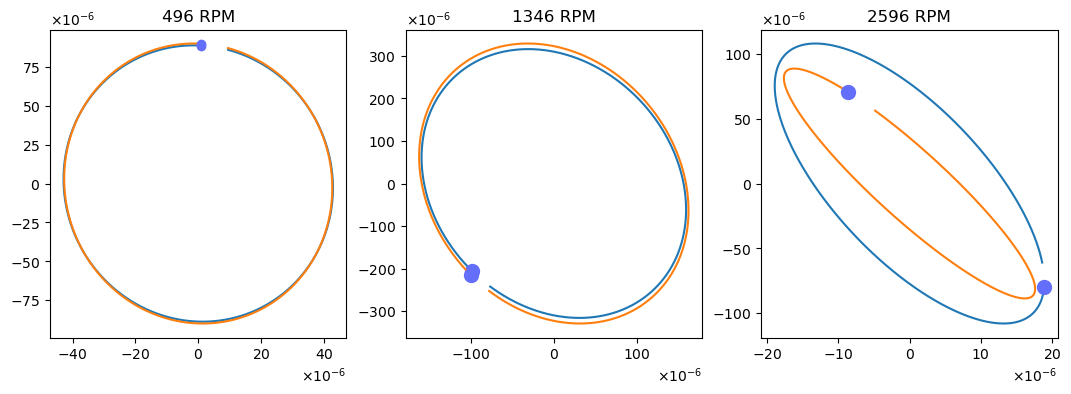

In [19]:
##### PLOTTING THE ORBITS 

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 4))

# Scaling the graphs in multiples of 1e-6

formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-6,-6))

# Choosing a proper cutoff the avoiding transient data and build an almost 360 degrees of the orbit
cutoff = -int(time_samples * 0.0018)

# Plot orbit data at 496 RPM
ax1.plot(x1_axis_displacement[cutoff:], y1_axis_displacement[cutoff:], label='Orbit')
ax1.plot(x1_axis_displacement[cutoff:][0], y1_axis_displacement[cutoff:][0], 'o', markersize=6, color='#636EFA')
ax1.plot(x2_axis_displacement[cutoff:], y2_axis_displacement[cutoff:], label='Orbit')
ax1.plot(x2_axis_displacement[cutoff:][0], y2_axis_displacement[cutoff:][0], 'o', markersize=6, color='#636EFA')
ax1.set_title('496 RPM') 
ax1.xaxis.set_major_formatter(formatter)
ax1.yaxis.set_major_formatter(formatter)

cutoff = -int(time_samples * 0.0017)

# Plot orbit data at 1346 RPM
ax2.plot(x3_axis_displacement[cutoff:], y3_axis_displacement[cutoff:], label='Orbit')
ax2.plot(x3_axis_displacement[cutoff:][0], y3_axis_displacement[cutoff:][0], 'o', markersize=10, color='#636EFA')
ax2.plot(x4_axis_displacement[cutoff:], y4_axis_displacement[cutoff:], label='Orbit')
ax2.plot(x4_axis_displacement[cutoff:][0], y4_axis_displacement[cutoff:][0], 'o', markersize=10, color='#636EFA')
ax2.set_title('1346 RPM') 
ax2.xaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)

cutoff = -int(time_samples * 0.00058)

# Plot orbit data at 2596 RPM
ax3.plot(x5_axis_displacement[cutoff:], y5_axis_displacement[cutoff:], label='Orbit')
ax3.plot(x5_axis_displacement[cutoff:][0], y5_axis_displacement[cutoff:][0], 'o', markersize=10, color='#636EFA')
ax3.plot(x6_axis_displacement[cutoff:], y6_axis_displacement[cutoff:], label='Orbit')
ax3.plot(x6_axis_displacement[cutoff:][0], y6_axis_displacement[cutoff:][0], 'o', markersize=10, color='#636EFA')
ax3.set_title('2596 RPM') 
ax3.xaxis.set_major_formatter(formatter)
ax3.yaxis.set_major_formatter(formatter)

## Major Axis Amplitude of the response at nodes 2 and 4

In [20]:
n1 = 2    # out-of-balancing is positioned at the left disk
m1 = 0.001  # amount of out-of-balancing expressed in kg*m
p1 = 0      # ou-of-balancing mass phase position
speed = Q_(np.linspace(0, 4500, 950),"RPM")
results_case1 = rotor.run_unbalance_response([n1], [m1], [p1], speed)
probe1 = (2, 'major')                  # response at major axis at the left disk of rotor (node = 2)
probe2 = (4, 'major')      # response at major axis at the right disk of rotor (node = 4)

fig = results_case1.plot_magnitude(probe = [probe1,probe2], probe_units="degrees",frequency_units="RPM", amplitude_units="µm pkpk",)

# changing to log scale

fig.update_layout(
        title = 'Major Axis Amplitude (µm pkpk)',
        yaxis=dict(
            title='Amplitude (µm pkpk)',
            type='log',
            )
    )

c:\users\ut6e\ross\ross\results.py:280: RuntimeWarning:

invalid value encountered in scalar divide



### REFERENCES
[1] M. I. Friswell, J. E. T. Penny, S. D. Garvey, and A. W. Lees, Dynamics of Rotating Machines. Cambridge: Cambridge University Press, 2010.